In [ ]:
# Unzip training and test datasets to data directory
# !unzip facial_kaypoints_data/training.zip -d facial_kaypoints_data
# !unzip facial_kaypoints_data/test.zip -d facial_kaypoints_data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from torch import nn, optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

In [3]:
data_dir = Path('./facial_kaypoints_data')
train_data = pd.read_csv(data_dir / 'training.csv')

In [5]:
def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

In [6]:
def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

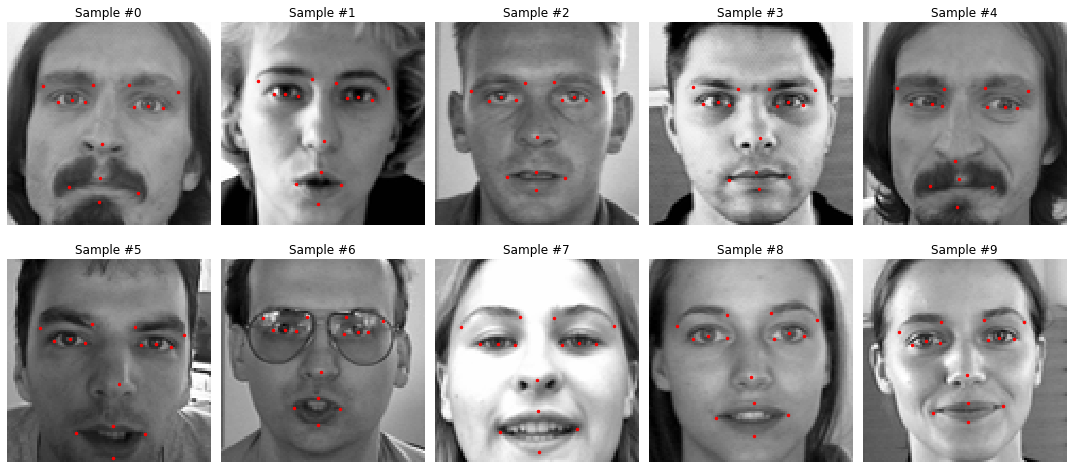

In [7]:
# View train images
show_images(train_data, range(10))

In [8]:
# Explore missing-any-data
# missing_any_data = train_data.drop(train_data.dropna().index)
missing_any_data = train_data[train_data.isnull().any(axis=1)]
missing_any_data.T.tail(10)

210   \
nose_tip_y                                                           61.2787   
mouth_left_corner_x                                                  57.8848   
mouth_left_corner_y                                                  87.4592   
mouth_right_corner_x                                                 34.2931   
mouth_right_corner_y                                                 85.1578   
mouth_center_top_lip_x                                                46.377   
mouth_center_top_lip_y                                               79.1162   
mouth_center_bottom_lip_x                                                NaN   
mouth_center_bottom_lip_y                                                NaN   
Image                      181 56 47 59 65 71 86 66 32 22 17 7 8 12 13 14...   

                                                                        350   \
nose_tip_y                                                           62.1639   
mouth_left_corner_x                                                   57.029   
mouth_left_corner_y                                                  86.7783   
mouth_right_corner_x                                                  36.251   
mouth_right_corner_y                                                 87.0976   
mouth_center_top_lip_x                                               45.2018   
mouth_center_top_lip_y                                               79.1061   
mouth_center_bottom_lip_x                                                NaN   
mouth_center_bottom_lip_y                                                NaN   
Image                      59 41 36 32 32 31 33 41 55 72 79 70 64 50 52 6...   

                                                                        499   \
nose_tip_y                                                           58.1808   
mouth_left_corner_x                                                  56.9185   
mouth_left_corner_y                                                  85.4828   
mouth_right_corner_x                                                 28.1978   
mouth_right_corner_y                                                 81.9372   
mouth_center_top_lip_x                                               45.9269   
mouth_center_top_lip_y                                               75.5544   
mouth_center_bottom_lip_x                                                NaN   
mouth_center_bottom_lip_y                                                NaN   
Image                      118 127 122 109 129 154 158 148 147 152 136 13...   

                                                                        512   \
nose_tip_y                                                           59.5908   
mouth_left_corner_x                                                  64.7701   
mouth_left_corner_y                                                  82.8008   
mouth_right_corner_x                                                 33.8235   
mouth_right_corner_y                                                  82.449   
mouth_center_top_lip_x                                               48.2416   
mouth_center_top_lip_y                                               71.5475   
mouth_center_bottom_lip_x                                                NaN   
mouth_center_bottom_lip_y                                                NaN   
Image                      194 194 194 191 194 191 191 183 166 151 126 86...   

                                                                        810   \
nose_tip_y                                                           57.7843   
mouth_left_corner_x                                                  65.1619   
mouth_left_corner_y                                                  83.2227   
mouth_right_corner_x                                                 28.7133   
mouth_right_corner_y                                                 82.4632   
mouth_center_top_lip_x                                              

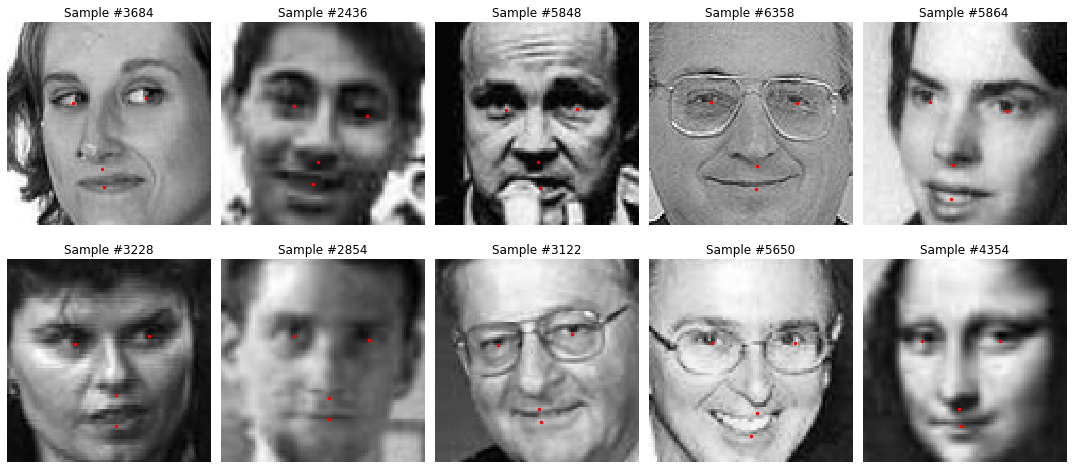

In [9]:
# View random missing-any-data images
idxs = missing_any_data.index
idxs = np.random.choice(idxs, 10)
show_images(train_data, idxs)

In [10]:
# Explore missing-bottom-lip-only data
missing_bottom_lip_only = train_data[(train_data.mouth_center_bottom_lip_x.isnull() & train_data.mouth_center_top_lip_x.notnull())]
missing_bottom_lip_only.T.tail(10)

210   \
nose_tip_y                                                           61.2787   
mouth_left_corner_x                                                  57.8848   
mouth_left_corner_y                                                  87.4592   
mouth_right_corner_x                                                 34.2931   
mouth_right_corner_y                                                 85.1578   
mouth_center_top_lip_x                                                46.377   
mouth_center_top_lip_y                                               79.1162   
mouth_center_bottom_lip_x                                                NaN   
mouth_center_bottom_lip_y                                                NaN   
Image                      181 56 47 59 65 71 86 66 32 22 17 7 8 12 13 14...   

                                                                        350   \
nose_tip_y                                                           62.1639   
mouth_left_corner_x                                                   57.029   
mouth_left_corner_y                                                  86.7783   
mouth_right_corner_x                                                  36.251   
mouth_right_corner_y                                                 87.0976   
mouth_center_top_lip_x                                               45.2018   
mouth_center_top_lip_y                                               79.1061   
mouth_center_bottom_lip_x                                                NaN   
mouth_center_bottom_lip_y                                                NaN   
Image                      59 41 36 32 32 31 33 41 55 72 79 70 64 50 52 6...   

                                                                        499   \
nose_tip_y                                                           58.1808   
mouth_left_corner_x                                                  56.9185   
mouth_left_corner_y                                                  85.4828   
mouth_right_corner_x                                                 28.1978   
mouth_right_corner_y                                                 81.9372   
mouth_center_top_lip_x                                               45.9269   
mouth_center_top_lip_y                                               75.5544   
mouth_center_bottom_lip_x                                                NaN   
mouth_center_bottom_lip_y                                                NaN   
Image                      118 127 122 109 129 154 158 148 147 152 136 13...   

                                                                        512   \
nose_tip_y                                                           59.5908   
mouth_left_corner_x                                                  64.7701   
mouth_left_corner_y                                                  82.8008   
mouth_right_corner_x                                                 33.8235   
mouth_right_corner_y                                                  82.449   
mouth_center_top_lip_x                                               48.2416   
mouth_center_top_lip_y                                               71.5475   
mouth_center_bottom_lip_x                                                NaN   
mouth_center_bottom_lip_y                                                NaN   
Image                      194 194 194 191 194 191 191 183 166 151 126 86...   

                                                                        810   \
nose_tip_y                                                           57.7843   
mouth_left_corner_x                                                  65.1619   
mouth_left_corner_y                                                  83.2227   
mouth_right_corner_x                                                 28.7133   
mouth_right_corner_y                                                 82.4632   
mouth_center_top_lip_x                                              

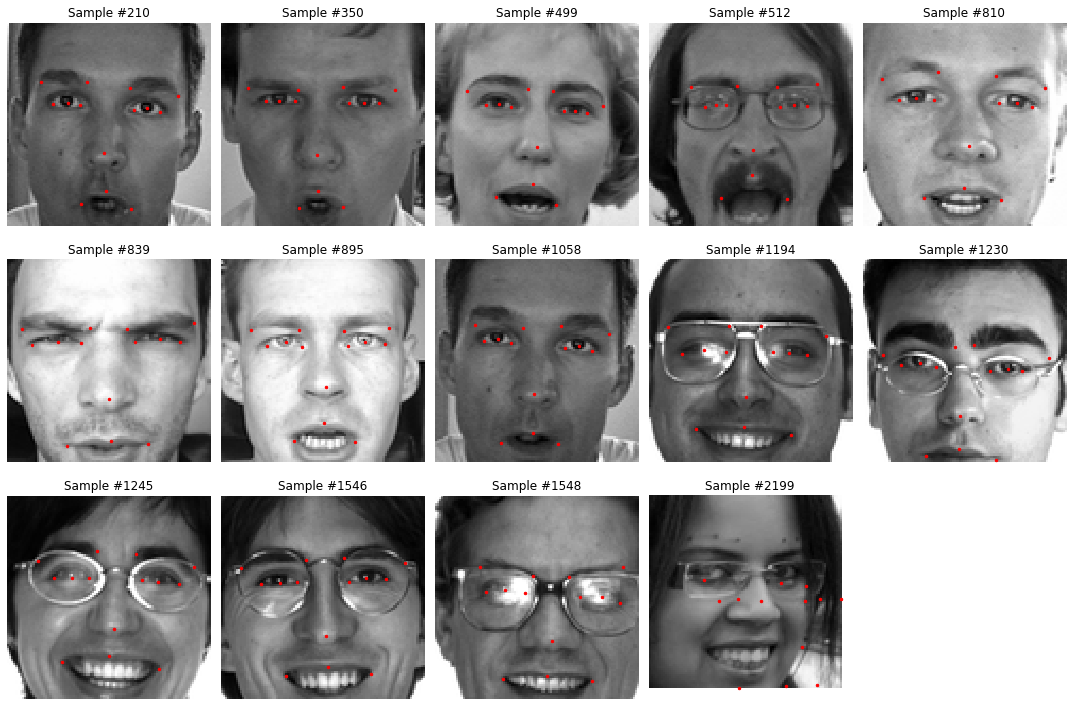

In [11]:
# View missing-bottom-lip-only images
idxs = missing_bottom_lip_only.index
show_images(train_data, idxs)

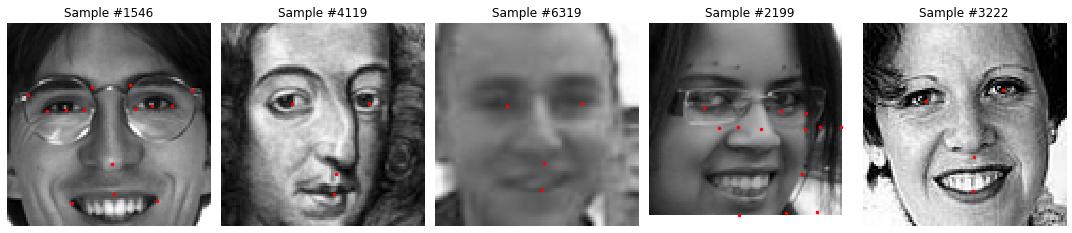

In [12]:
show_images(train_data, [1546, 4119, 6319, 2199, 3222])
#blur (#6319), cropped (#1546), and even missed-annotated sample (#2199)

In [13]:
test_data = pd.read_csv(data_dir / 'test.csv')
train_df = train_data.dropna()

# test_data.info()

In [15]:
class FaceKeypointsDataset(Dataset):    
    def __init__(self, dataframe, train=True, transform=None):
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None

        sample = {'image': image, 'keypoints': keypoints}
        
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [16]:
class Normalize(object):
    '''Normalize input images'''
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

In [17]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [18]:
# drop any-missing-keypoint records
train_df = train_data.dropna()
test_df = test_data

# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2

# Define a transform to normalize the data
tsfm = transforms.Compose([Normalize(), ToTensor()])

# Load the training data and test data
trainset = FaceKeypointsDataset(train_df, transform=tsfm)
testset = FaceKeypointsDataset(test_df, train=False, transform=tsfm)

# prepare data loaders
train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [19]:
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        
        '''
        Buid a forward network with arbitrary hidden layers.
        
        Arguments
            ---------
            input_size (integer): size of the input layer
            output_size (integer): size of the output layer
            hidden_layers (list of integers):, the sizes of each hidden layers
        '''
        
        super(MLP, self).__init__()
        
        # hidden layers
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) 
                                            for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # flatten inputs
        x = x.view(x.shape[0], -1)
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [22]:
model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=30, 
            hidden_layers=[128, 64], drop_p=0.1)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [25]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        # train 

        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        # validate 
        
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses  

In [26]:
train_losses, valid_losses = train(train_loader, valid_loader, model,
                                   criterion, optimizer, n_epochs=50, 
                                   saved_model='model.pt')

Epoch: 1 	Training Loss: 32.848739 	Validation Loss: 16.513342
Validation loss decreased (inf --> 16.513342).  Saving model ...
Epoch: 2 	Training Loss: 17.088331 	Validation Loss: 13.012389
Validation loss decreased (16.513342 --> 13.012389).  Saving model ...
Epoch: 3 	Training Loss: 14.843249 	Validation Loss: 12.262789
Validation loss decreased (13.012389 --> 12.262789).  Saving model ...
Epoch: 4 	Training Loss: 14.301018 	Validation Loss: 12.042777
Validation loss decreased (12.262789 --> 12.042777).  Saving model ...
Epoch: 5 	Training Loss: 13.496748 	Validation Loss: 11.767353
Validation loss decreased (12.042777 --> 11.767353).  Saving model ...
Epoch: 6 	Training Loss: 13.008696 	Validation Loss: 11.247985
Validation loss decreased (11.767353 --> 11.247985).  Saving model ...
Epoch: 7 	Training Loss: 12.519734 	Validation Loss: 10.844519
Validation loss decreased (11.247985 --> 10.844519).  Saving model ...
Epoch: 8 	Training Loss: 11.774560 	Validation Loss: 10.447404
Valid

In [27]:
# Function to plot RMSE vs epochs
def plot_RMSE(train_losses, valid_losses, y_max=50):
    plt.plot(train_losses, "--", linewidth=3, label="train")
    plt.plot(valid_losses, linewidth=3, label="val")
    plt.legend()
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.ylim((0, y_max))
    plt.show()

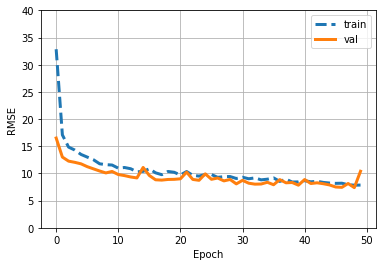

In [28]:
plot_RMSE(train_losses, valid_losses, y_max=40)

In [29]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

In [30]:
def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    '''
    Display predicted keypoints
    Args:
        columns (array-like): column names
        test_df (DataFrame): dataframe with ImageId and Image columns
        predictions (array-like): keypoints in float (no. of images x keypoints)
        image_id (array-like): list or range of ImageIds begin at 1
    '''
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  # ImageId as index begin at 1

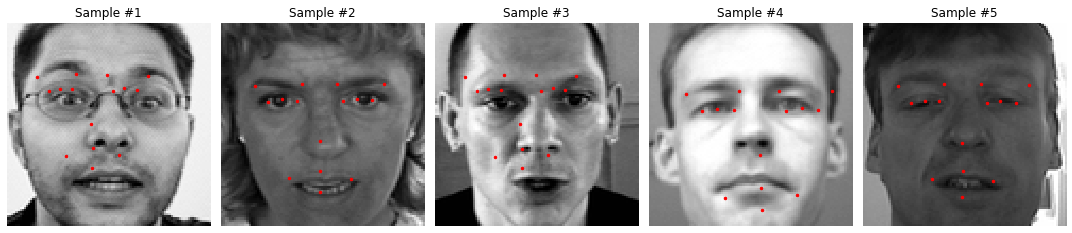

In [31]:
# Load the minimum valuation loss model
model.load_state_dict(torch.load('model.pt'))
predictions = predict(test_loader, model)
columns = train_df.drop('Image', axis=1).columns
view_pred_df(columns, test_df, predictions)

In [38]:
def create_submission(predictions, pred_file='facial_kaypoints_data/preds.csv', sub_file='facial_kaypoints_data/submission.csv', columns=None):
    '''
    Create csv file for submission from predictions
    Args:
        predictions (array-like): prediction (no. fo images x 30 keypoints)
        pred_file (string): file path for prediction csv file
        sub_file (string): file path for submission csv file
        columns (dict): provided column names for submission file
    '''
    lookup = pd.read_csv('facial_kaypoints_data/IdLookupTable.csv')
    if columns == None:
        columns = train_data.columns[:-1]
    preds = pd.DataFrame(predictions, 
                         index=np.arange(1, len(predictions)+1), 
                         columns=columns)
    preds.to_csv(pred_file)
    locations = [preds.loc[image_id, feature_name] 
                 for image_id, feature_name 
                 in lookup[['ImageId', 'FeatureName']].values]
    locations = [location if location < IMG_SIZE else IMG_SIZE for location in locations]
    lookup.Location = pd.Series(locations)
    lookup[['RowId', 'Location']].to_csv(sub_file, index=False)

In [39]:
create_submission(predictions)

In [40]:
submission = pd.read_csv('facial_kaypoints_data/submission.csv')
submission.head()

RowId   Location
0      1  54.520008
1      2  30.480663
2      3  24.505304
3      4  30.673290
4      5  49.362656

In [41]:
class RandomHorizontalFlip(object):
    '''
    Horizontally flip image randomly with given probability
    Args:
        p (float): probability of the image being flipped.
                   Defalut value = 0.5
    '''
    
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        
        flip_indices = [(0, 2), (1, 3),
                        (4, 8), (5, 9), (6, 10), (7, 11),
                        (12, 16), (13, 17), (14, 18), (15, 19),
                        (22, 24), (23, 25)]
        
        image, keypoints = sample['image'], sample['keypoints']
        
        if np.random.random() < self.p:
            image = image[:, ::-1]
            if keypoints is not None:
                for a, b in flip_indices:
                    keypoints[a], keypoints[b]= keypoints[b], keypoints[a]
                keypoints[::2] = 96. - keypoints[::2]
        
        return {'image': image, 
                'keypoints': keypoints}

In [42]:
aug_train_df = train_data.dropna()
aug_transform = transforms.Compose([RandomHorizontalFlip(p=1.0), 
                                    Normalize(),
                                    ToTensor()])
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_transform)

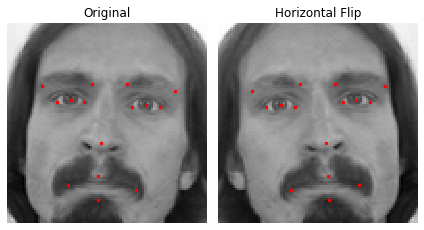

In [43]:
plt.subplot(1,2,1)
plt.title(f'Original')
plt.axis('off')
plt.tight_layout()
image = trainset[0]['image'].numpy().squeeze()
keypoints = trainset[0]['keypoints'].numpy().reshape(-1,2)
show_keypoints(image, keypoints)
plt.subplot(1,2,2)
plt.title(f'Horizontal Flip')
plt.axis('off')
plt.tight_layout()
image = aug_trainset[0]['image'].numpy().squeeze()
keypoints = aug_trainset[0]['keypoints'].numpy().reshape(-1,2)
show_keypoints(image, keypoints)

In [44]:
def show_dataset_images(dataset, n_images=10, n_cols=5, figsize=(15,10)):
    '''
    Show Dataset images with keypoints in grids
    Args:
        dataset (Dataset): data
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if data consists of keypoint data
    '''
        
    plt.figure(figsize=figsize)
    n_rows = n_images // n_cols + 1
    for idx in range(n_images):
        image = dataset[idx]['image'].numpy().squeeze()
        keypoints = dataset[idx]['keypoints'].numpy().reshape(-1,2)
        plt.subplot(n_rows, n_cols, idx+1)
        plt.grid(False)
        plt.tight_layout()
        show_keypoints(image, keypoints)

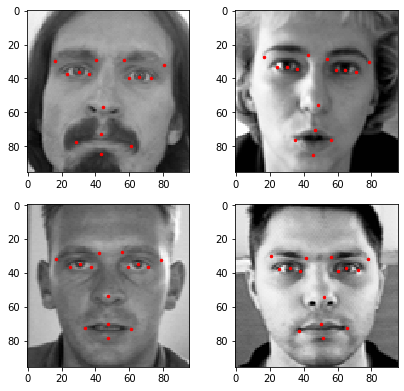

In [45]:
# Original 
show_dataset_images(trainset, 4, 2, (6,8))

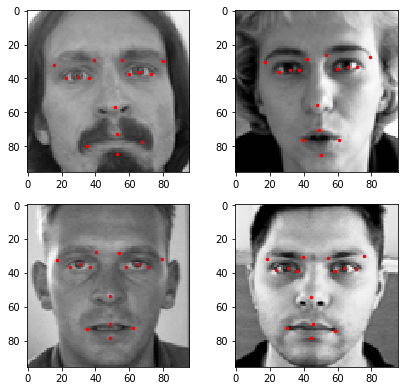

In [46]:
# Horizontal Flip
show_dataset_images(aug_trainset, 4, 2, (6,8))

In [47]:
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2


# Drop missing data
aug_train_df = train_data.dropna()

# Define a transform to augment the data
aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5),
                                    Normalize(),
                                    ToTensor()])

# Load the training data
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_tfms)


# prepare data loaders
aug_train_loader, aug_valid_loader = prepare_train_valid_loaders(aug_trainset, 
                                                                 valid_size,
                                                                 batch_size)

In [48]:
model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=30, hidden_layers=[128, 64], drop_p=0.1)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [49]:
aug_train_losses, aug_valid_losses = train(aug_train_loader, aug_valid_loader, model, criterion, 
                                           optimizer, n_epochs=50, saved_model='aug_model.pt')

Epoch: 1 	Training Loss: 33.816332 	Validation Loss: 18.600836
Validation loss decreased (inf --> 18.600836).  Saving model ...
Epoch: 2 	Training Loss: 18.084933 	Validation Loss: 13.870520
Validation loss decreased (18.600836 --> 13.870520).  Saving model ...
Epoch: 3 	Training Loss: 15.326987 	Validation Loss: 12.551571
Validation loss decreased (13.870520 --> 12.551571).  Saving model ...
Epoch: 4 	Training Loss: 14.609190 	Validation Loss: 11.975464
Validation loss decreased (12.551571 --> 11.975464).  Saving model ...
Epoch: 5 	Training Loss: 14.041856 	Validation Loss: 11.718367
Validation loss decreased (11.975464 --> 11.718367).  Saving model ...
Epoch: 6 	Training Loss: 13.542139 	Validation Loss: 11.882865
Epoch: 7 	Training Loss: 13.445421 	Validation Loss: 11.098066
Validation loss decreased (11.718367 --> 11.098066).  Saving model ...
Epoch: 8 	Training Loss: 12.879832 	Validation Loss: 11.472078
Epoch: 9 	Training Loss: 13.071518 	Validation Loss: 12.377885
Epoch: 10 	Tr

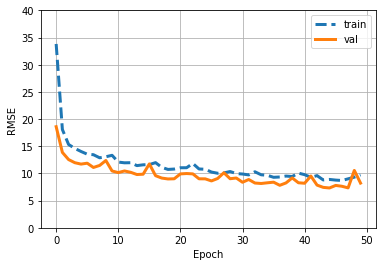

In [50]:
plot_RMSE(aug_train_losses, aug_valid_losses, y_max=40)

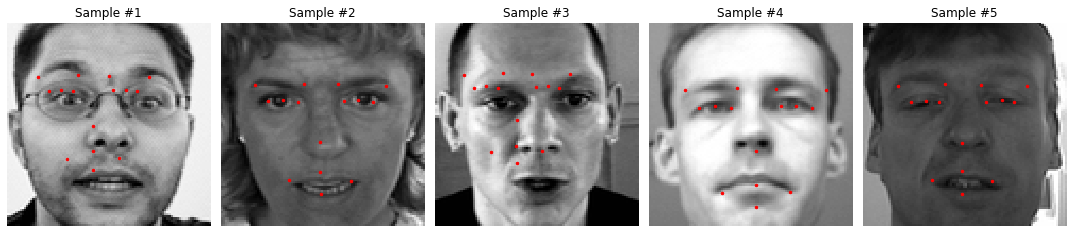

In [51]:
model.load_state_dict(torch.load('aug_model.pt'))
predictions = predict(test_loader, model)
columns = train_df.drop('Image', axis=1).columns
view_pred_df(columns, test_df, predictions)

In [54]:
create_submission(predictions, 
                  pred_file='facial_kaypoints_data/aug_mlp_preds.csv', 
                  sub_file='facial_kaypoints_data/aug_mlp_submission.csv')

In [55]:
class CNN(nn.Module):
    '''
    Convolutional Neural Network model
            
    Args:
        ---------
        output_size (integer): size of the output layer
    '''
    
    def __init__(self, outputs=30):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x

Now let's train CNN model with augmented data.

In [56]:
model = CNN(outputs=30)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [57]:
aug_cnn_train_losses, aug_cnn_valid_losses = train(aug_train_loader, aug_valid_loader, model, criterion, 
                                                   optimizer, n_epochs=50, saved_model='aug_cnn.pt')

Epoch: 1 	Training Loss: 29.561549 	Validation Loss: 8.021635
Validation loss decreased (inf --> 8.021635).  Saving model ...
Epoch: 2 	Training Loss: 11.187425 	Validation Loss: 5.457164
Validation loss decreased (8.021635 --> 5.457164).  Saving model ...
Epoch: 3 	Training Loss: 6.614505 	Validation Loss: 3.825543
Validation loss decreased (5.457164 --> 3.825543).  Saving model ...
Epoch: 4 	Training Loss: 4.837188 	Validation Loss: 3.833050
Epoch: 5 	Training Loss: 4.379329 	Validation Loss: 3.507960
Validation loss decreased (3.825543 --> 3.507960).  Saving model ...
Epoch: 6 	Training Loss: 4.247549 	Validation Loss: 3.668702
Epoch: 7 	Training Loss: 4.193272 	Validation Loss: 3.345829
Validation loss decreased (3.507960 --> 3.345829).  Saving model ...
Epoch: 8 	Training Loss: 4.077653 	Validation Loss: 3.358481
Epoch: 9 	Training Loss: 3.988292 	Validation Loss: 3.287555
Validation loss decreased (3.345829 --> 3.287555).  Saving model ...
Epoch: 10 	Training Loss: 4.020522 	Vali

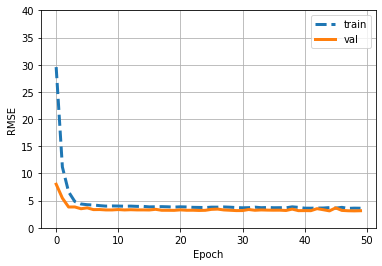

In [58]:
plot_RMSE(aug_cnn_train_losses, aug_cnn_valid_losses, y_max=40)

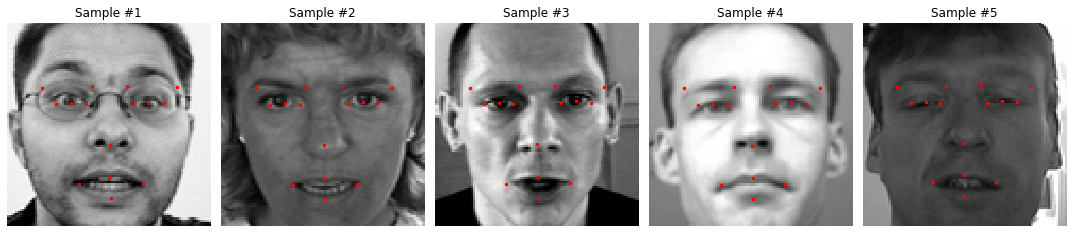

In [59]:
model.load_state_dict(torch.load('aug_cnn.pt'))

predictions = predict(test_loader, model)

create_submission(predictions, 
                  pred_file='data/aug_cnn_preds.csv', 
                  sub_file='data/aug_cnn_submission.csv')

view_pred_df(columns, test_df, predictions)